# Capítulo 3 - Clasificación

# Configuración

In [1]:
# imports comunes
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Hacer las salidas de este notebook estables a través de ejecuciones
np.random.seed(42)

# Hacemos algunos ajustes a los gráficos
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Donde grabar las figuras
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "clasificacion"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Grabando figura", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Ignorar warning inútiles (ver SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# MNIST

`fetch_mldata()` está en desuso desde Scikit-Learn 0.20. Deberemos usar `fetch_openml()` en su lugar. Sin embargo, devuelve el conjunto de datos MNIST sin clasificar, mientras que `fetch_mldata()` devuelve el conjunto de datos ordenado por objetivo (el conjunto de entrenamiento yde prueba se clasificaron por separado). En general, esto está bien, pero si deseamos obtener exactamente los mismos resultados que antes, debemos ordenar el conjunto de datos utilizando la siguiente función:

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
from sklearn.datasets import fetch_openml

In [4]:
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() devuelve targets como cadenas
sort_by_target(mnist) # fetch_openml() devuelve un dataset sin ordenar
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

Generalmente, los dataset cargados de Scikit-Learn tiene una estructura similar de diccionario, incluyendo:

+ una clave `DESCR` describiendo el dataset
+ una clave `data` conteniendo un array con una fila por cada instancia y una columna por cada característica
+ una clave `target` conteniendo un array con las etiquetas (objetivo)

In [5]:
mnist["data"].shape

(70000, 784)

In [6]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

In [8]:
28*28

784

Es decir, 70.000 imágenes y 784 características. Esto es así porque cada imagen está son 28x28 pixels y cada característica representa un pixel de intensidad, de 0 (blanco) a 255 (negro). Echemos un vistazo a un dígito del conjunto de datos. Todo lo que necesitamos es tomar el vector de características de una instancia, cambiarlo a una matriz de 28 × 28 y mostrarlo usando la función `imshow()` de Matplotlib:

Grabando figura some_digit_plot


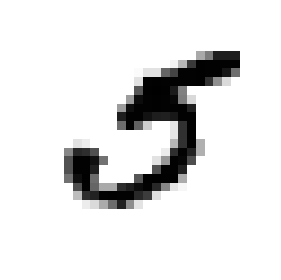

In [9]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

Parece un 5, veamos cuál es su etiqueta:

In [10]:
y[36000]

5

In [11]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [12]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Grabando figura more_digits_plot


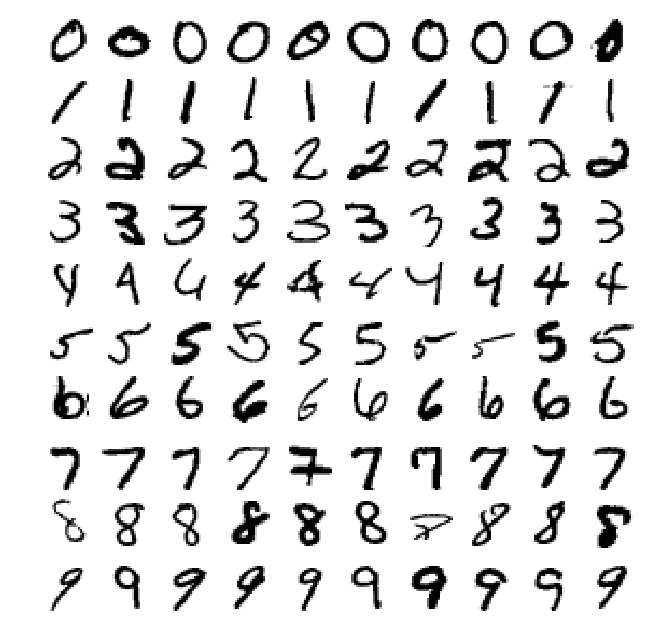

In [13]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

Siempre debemos crear un conjunto de pruebas y apartarlo antes de inspeccionar los datos de cerca. El conjunto de datos MNIST ya está dividido en un conjunto de entrenamiento (las primeras 60.000 imágenes) y un conjunto de prueba (las últimas 10.000 imágenes):

In [14]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Vamos a mezclar también el conjunto de entrenamiento; esto garantizará que todos los folds de validación cruzada sean similares (no querremos que falten algunos dígitos en un fold). Además, algunos algoritmos de aprendizaje son sensibles al orden de las instancias de entrenamiento y tienen un bajo rendimiento si obtienen muchas instancias similares seguidas. Al barajar el conjunto de datos se garantiza que esto no suceda:

In [15]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Entrenando un clasificador binario

Vamos a simplificar el problemas y vamos a tratar de detectar si un número es un 5 o no lo es (*clasificador binario*). Creemos los vectores objetivo de esta tarea de clasificación:

In [16]:
y_train_5 = (y_train == 5)  # True para todos los 5's, False para el resto de números
y_test_5 = (y_test == 5)

Bien, ahora vamos a elegir un clasificador y entrenarlo. Un buen lugar para comenzar es con un clasificador *Stochastic Gradient Descent* (SGD), utilizando la clase `SGDClassifier` de Scikit-Learn. Este clasificador tiene la ventaja de ser capaz de manejar conjuntos de datos muy grandes de manera eficiente. Esto se debe en parte a que SGD se ocupa de las instancias de capacitación de forma independiente, una a la vez (lo que también hace que la SGD sea adecuado para el aprendizaje en línea).

In [17]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

Ahora puedes usarlo para detectar imágenes del número 5

In [18]:
sgd_clf.predict([some_digit])

array([ True])

# Medidas del rendimiento

## Medición de la precisión mediante cross validation

In [19]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9502 , 0.96565, 0.96495])

¿Más del 95% de precisión (relación de predicciones correctas) en todos los folds de validación cruzada? Esto es increíble, ¿no? Bueno, antes de que nos emociones demasiado, pensemos en un clasificador muy tonto que simplemente clasifica cada imagen en la clase "no 5" y que devuelve True siempre. Tendría más del 90% de precisión. Esto se debe simplemente a que solo el 10% de las imágenes son 5, por lo que si siempre adivina que una imagen no es un 5, tendrá razón aproximadamente el 90% del tiempo. 

Esto demuestra por qué la precisión generalmente no es la medida de rendimiento preferida para los clasificadores, especialmente cuando se trata de conjuntos de datos sesgados (es decir, cuando algunas clases son mucho más frecuentes que otras).

## Matriz de confusión

Una forma mucho mejor de evaluar la ejecución de un clasificador es la *matriz de confusión*. La idea general es contar el número de veces que las instancias de la clase A son clasificadas como clase B. Antes de calcular la matriz de confusión necesitamos un conjunto de predicciones, para poder compararlas con los targets actuales. Para evitar tocar los datos de prueba utilizaremos la función `cross_val_predict()`.

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Ahora ya estamos preparados para obtener la matriz de confusión usando `confusion_matrix()`:

In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]], dtype=int64)

Cada fila en una matriz de confusión representa una *clase real*, mientras que cada columna representa una *clase predicha*. La primera fila de esta matriz considera imágenes no-5 (la clase negativa): 53.272 de ellas se clasificaron correctamente como no-5 (se llaman negativas verdaderas), mientras que las 1.307 restantes se clasificaron erróneamente como 5s (falsos positivos). La segunda fila considera las imágenes de 5s (la clase positiva): 1.077 se clasificaron erróneamente como no-5s (falsos negativos), mientras que los 4.344 restantes se clasificaron correctamente como 5s (verdaderos positivos). Un clasificador perfecto solo tendría verdaderos positivos y verdaderos negativos, por lo que su matriz de confusión tendría valores distintos de cero solo en su diagonal principal (arriba a la izquierda a la parte inferior derecha):

In [22]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

La matriz de confusión proporciona mucha información, pero a veces podemos preferir una métrica más concisa. Una interesante es la precisión de las predicciones positivas: esto se llama la *precisión* del clasificador.

precisión = TP / (TP + FP). Es decir, la precisión se calcula como True Positive dividido por la suma de True Positive más False Positive.

Una forma trivial de tener una precisión perfecta es hacer una sola predicción positiva y asegurarse de que sea correcta (precisión = 1/1 = 100%). Esto no sería muy útil ya que el clasificador ignoraría todas las instancias, excepto una positiva. Por lo tanto, la precisión se usa normalmente junto con otra métrica llamada *recall*, también llamada *sensibilidad* o *true positive ratio* (TPR): esta es la proporción de instancias positivas que el clasificador detecta correctamente.

recall = TP / (TP + FN), es decir, True Positive dividido por la suma de True Positive más False Negative.

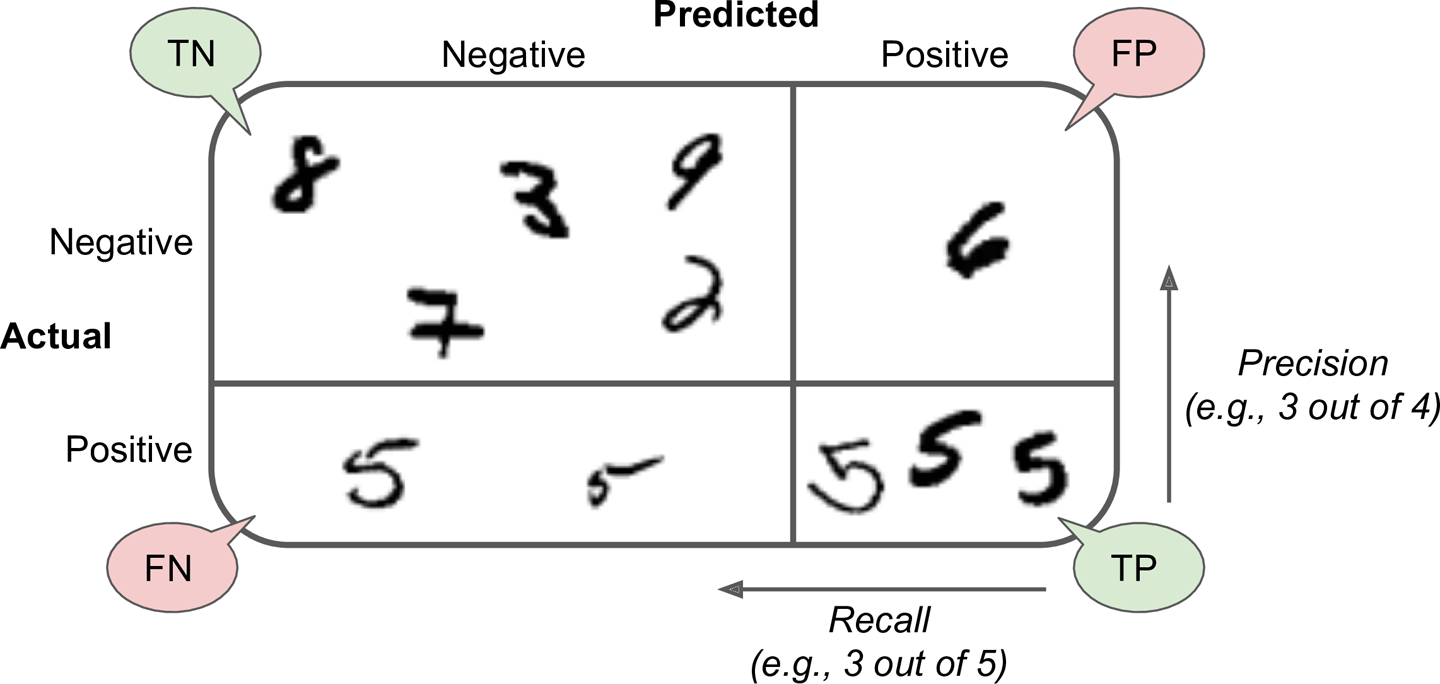

In [23]:
from IPython.display import Image
Image(filename=PROJECT_ROOT_DIR + "/images/clasificacion/confusion_matrix.png")

## Precisión y Sensibilidad

In [24]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7687135020350381

Vamos a comprobar que es correcto de forma manual:

In [25]:
4344 / (4344 + 1307)

0.7687135020350381

In [26]:
recall_score(y_train_5, y_train_pred)

0.801328168234643

In [27]:
4344 / (4344 + 1077)

0.801328168234643

Parece que ahora nuestro detector de 5s no se ve tan brillante como lo hizo cuando calculamos su precisión. Cuando dice que una imagen representa un 5, es correcto solo el 77% de las veces. Además, solo detecta el 80% de los 5s.

A menudo es conveniente combinar precisión y recuperación en una sola métrica llamada puntuación F1 (*F1 score*), en particular si necesitamos una forma sencilla de comparar dos clasificadores. La puntuación de F1 es la *media armónica* de precisión y sensibilidad (ecuación 3-3). Mientras que la media regular trata a todos los valores por igual, la media armónica otorga mucho más peso a los valores bajos. Como resultado, el clasificador solo obtendrá una puntuación alta en F1 si tanto la sensibilidad como la precisión son altas.

In [28]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7846820809248555

In [29]:
4344 / (4344 + (1077 + 1307)/2)

0.7846820809248555

La puntuación de F1 favorece a los clasificadores que tienen una precisión y memoria similares. Esto no es siempre lo que queremos: en algunos contextos, nos importará la precisión y en otros contextos realmente nos importa recordar. Por ejemplo, si entrenamos a un clasificador para que detecte videos que son seguros para los niños, probablemente preferiremos un clasificador que rechace muchos videos buenos (recordatorios bajos) pero que mantenga solo los seguros (alta precisión), en lugar de un clasificador que tenga mucho mayor sensibilidad, pero que permita que algunos videos realmente malos se muestren en nuestro producto (en tales casos, es posible que deseemos agregar un control humano para verificar la selección de videos del clasificador). Por otro lado, supongamos que entrenamos a un clasificador para detectar ladrones en las imágenes de vigilancia: probablemente esté bien si su clasificador tiene solo un 30% de precisión, siempre que tenga un 99% de sensibilidad (seguro, los guardias de seguridad recibirán algunas alertas falsas, pero casi todos los ladrones serán atrapados).

Desafortunadamente, no podemos tenerlo de las dos maneras: aumentar la precisión reduce la sensibilidad, y viceversa. Esto se llama *compensación de precisión/sensibilidad*.

## Compensación precisión/sensibilidad

Para entender este compromiso, veamos cómo `SGDCClassifier` toma sus decisiones de clasificación. Para cada instancia, calcula una puntuación basada en una función de decisión y si esa puntuación es mayor que un umbral, asigna la instancia a la clase positiva, o bien la asigna a la clase negativa. En la siguiente figura se muestran algunos dígitos ubicados desde la puntuación más baja de la izquierda hasta la puntuación más alta de la derecha. Supongamos que el umbral de decisión se ubica en la flecha central (entre los dos 5): encontrará 4 verdaderos positivos (5 reales) a la derecha de ese umbral, y un falso positivo (en realidad un 6). Por lo tanto, con ese umbral la precisión es del 80% (4 de 5). Pero de 6 reales 5, el clasificador solo detecta 4, por lo que la recuperación es del 67% (4 de 6). Ahora, si aumenta el umbral (muévalo a la flecha de la derecha), el falso positivo (el 6) se convierte en un verdadero negativo, lo que aumenta la precisión (hasta el 100% en este caso), pero un verdadero positivo se convierte en un falso negativo, disminuyendo la recuperación hasta el 50%. Por el contrario, bajar el umbral aumenta la recuperación y reduce la precisión.

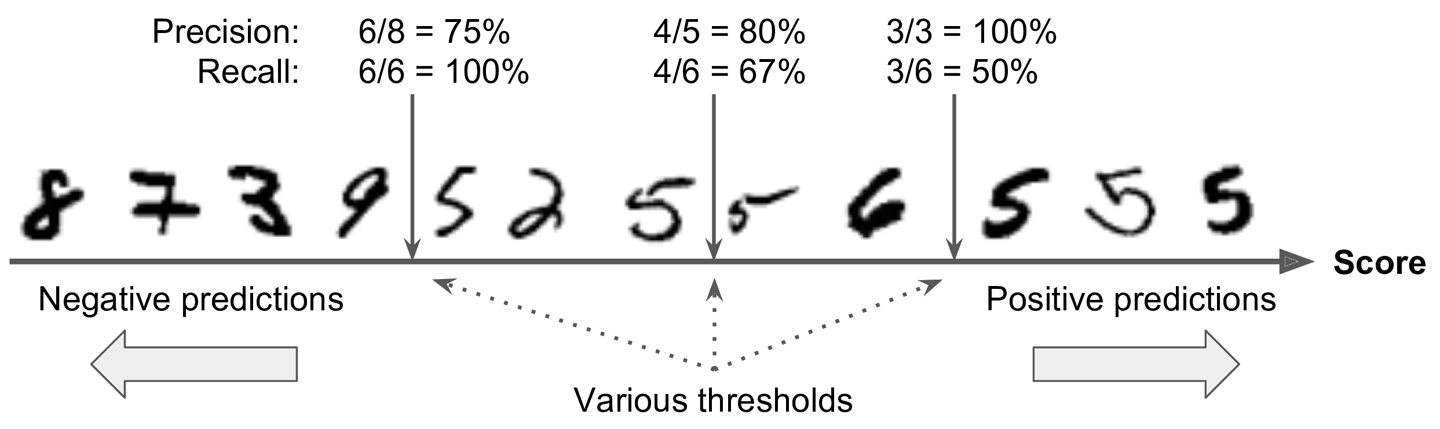

In [30]:
Image(filename=PROJECT_ROOT_DIR + "/images/clasificacion/decision_threshold.png")

Scikit-Learn no nos permite establecer el umbral directamente, pero nos da acceso a las puntuaciones de decisión que utiliza para hacer predicciones. En lugar de llamar al método `predict()` del clasificador, llamamos a su método `decision_function()`, que devuelve una puntuación para cada instancia y luego hacer predicciones basadas en esas puntuaciones utilizando cualquier umbral que deseemos:

In [31]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([161855.74572176])

In [32]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [33]:
y_some_digit_pred

array([ True])

`SGDClassifier` usa un umbral igual a 0, como vemos. Vamos a subir el umbral:

In [34]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Esto confirma que elevar el umbral disminuye la sensibilidad. La imagen en realidad representa un 5 y el clasificador lo detecta cuando el umbral es 0, pero lo pierde cuando el umbral se incrementa a 200.000. Entonces, ¿cómo podemos decidir qué umbral usar? Para ello, primero deberemos obtener las puntuaciones de todas las instancias en el conjunto de entrenamiento utilizando la función `cross_val_predict()` nuevamente, pero esta vez especificando que desea que devuelva las puntuaciones de decisión en lugar de las predicciones:

In [35]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Ahora, con estas puntuaciones podemos calcular la precisión y recuperar todos los umbrales posibles utilizando la función `precision_recall_curve()`:

In [36]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Grabando figura precision_recall_vs_threshold_plot


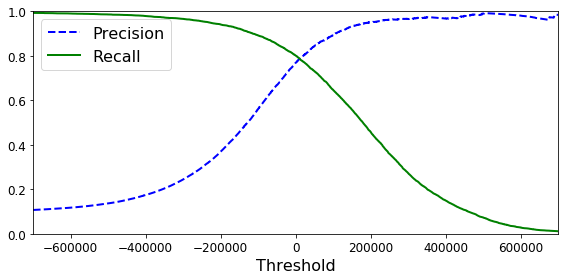

In [37]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

Ahora podemos simplemente seleccionar el valor de umbral que nos ofrezca la mejor compensación de precisión/sensibilidad para su tarea. 

Otra forma de seleccionar una buena precisión/sensibilidad es trazar la precisión directamente contra la sensibilidad:

Grabando figura precision_vs_recall_plot


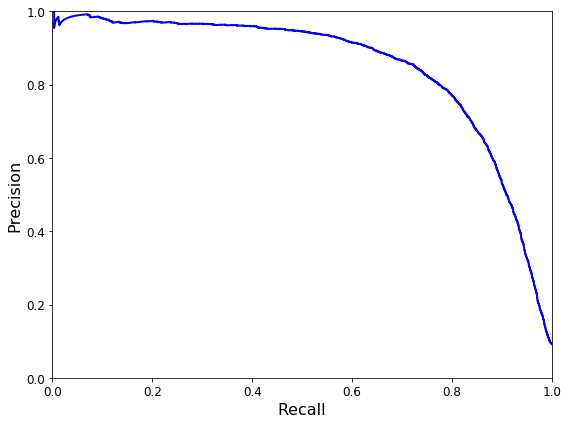

In [38]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

Se puede ver que la precisión realmente comienza a caer bruscamente en torno al 80% de sensibilidad. Es probable que queramos seleccionar una compensación de precisión/sensibilidad justo antes de esa caída, por ejemplo, en aproximadamente el 60% de sensibilidad. Pero, por supuesto, la elección depende de nuestro proyecto. Así que supongamos que decidimos apuntar a una precisión del 90%. Buscamos en el primer gráfico (acercando un poco el zoom) y descubrimos que necesitamos usar un umbral de aproximadamente 100.000. Para hacer predicciones (en el conjunto de entrenamiento por ahora), en lugar de llamar al método `predict()` del clasificador, podemos ejecutar este código:

In [39]:
(y_train_pred == (y_scores > 0)).all()

True

In [40]:
y_train_pred_90 = (y_scores > 100000)
precision_score(y_train_5, y_train_pred_90)

0.8935031847133758

In [41]:
recall_score(y_train_5, y_train_pred_90)

0.646928610957388

¡Genial, tenemos un clasificador de precisión del 90% (o lo suficientemente cerca)! Como vemos, es bastante fácil crear un clasificador con prácticamente cualquier precisión que desee: simplemente establezcamos un umbral lo suficientemente alto y listo. Hmm, no tan rápido. ¡Un clasificador de alta precisión no es muy útil si su sensibilidad es demasiado baja!

## La curva ROC